In [1]:
import utils
from hopfield import HopfieldNeuralNetwork
import numpy as np
import random
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('seaborn')

In [2]:
mwc = utils.MaxWeightedClique()

# Edge weights
G = np.array([[0, 1, 0, 0, 1, 0],
              [1, 0, 1, 0, 1, 0],
              [0, 1, 0, 1, 0, 0],
              [0, 0, 1, 0, 1, 1],
              [1, 1, 0, 1, 0, 0],
              [0, 0, 0, 1, 0, 0]])

# Node weights
Gn = np.array([2, 3, 4, 5, 2, 3])

# G = mwc.get_adj_matrix('max_clique_data/gen200_p0.9_44.clq', weights=False)  # Edge weights
# Gn = np.ones(G.shape[0])  # Node weights
print(G.shape)

W = 1 - G - np.eye(G.shape[0])
W = -len(Gn) * abs(Gn.max()) * W
Wn = -Gn

ones = np.ones(W.shape[0])

# Bias vector in terms of node weights and edge weights
b = W.T @ ones - 4 * np.array(Wn)

hnn = HopfieldNeuralNetwork(weights=W, bias=b, mode='ExponentialSmoothing')
n_steps = 1000
n_epochs = 200

# alpha_evol = np.linspace(0, 1, n_steps)
alpha_evol = np.logspace(5, -5, n_steps)
energies = np.zeros((n_epochs, n_steps))
idx_state = utils.PermutationStates(hnn.n_neurons)


def find_clique(hnn, n_steps, epoch, batch_size=0):
  '''`batch_size` lies in [0, 1]. If `batch_size` is 0, a single state of x is updated
  at a time. If `batch_size` is 1, all states of x are updated at a time.'''
  x = np.random.choice([-1, 1], size=hnn.n_neurons)
  for i, alpha in zip(range(n_steps), alpha_evol):
    if batch_size == 0: idx = idx_state.next()
    else: idx = random.sample(range(hnn.n_neurons), int(np.ceil(batch_size*hnn.n_neurons)))
    x[idx] = hnn.predict(x, alpha=alpha, indices=idx)
    energies[epoch][i] = mwc.energy(x, hnn.W, hnn.b)
  clique_val = mwc.energy(x, hnn.W, hnn.b)
  return clique_val, x

start = time.perf_counter()
best_clique_energy = np.inf
max_clique = None
for e in range(n_epochs):
  clique_val, y = find_clique(hnn, n_steps, e)
  # print(f'Epoch {e+1}: {clique_val}, {y}')
  if clique_val < best_clique_energy:
    best_clique_energy = clique_val
    max_clique = y

print(f'Max Clique value: {best_clique_energy}')
print(f'Finished in {time.perf_counter()-start:.2f} seconds')

(6, 6)
[[ -0. -30. -30.  -0.  -0.  -0.]
 [-30.  -0. -30. -30.  -0.  -0.]
 [-30. -30.  -0. -30.  -0.  -0.]
 [ -0. -30. -30.  -0. -30. -30.]
 [ -0.  -0.  -0. -30.  -0.  -0.]
 [ -0.  -0.  -0. -30.  -0.  -0.]] [-2 -3 -4 -5 -2 -3]


d:\Desktop\mem-HNNs\sims\hopfield.py:69: RuntimeWarning: overflow encountered in exp
  alpha/(np.exp(alpha/(self.W[self.idx]-self.W_avg)) - 1),
d:\Desktop\mem-HNNs\sims\hopfield.py:70: RuntimeWarning: overflow encountered in exp
  - alpha/(np.exp(alpha/(self.W_avg-self.W[self.idx])) - 1))
d:\Desktop\mem-HNNs\sims\hopfield.py:72: RuntimeWarning: overflow encountered in exp
  alpha/(np.exp(alpha/(self.b[self.idx]-self.b_avg)) - 1),
d:\Desktop\mem-HNNs\sims\hopfield.py:73: RuntimeWarning: overflow encountered in exp
  - alpha/(np.exp(alpha/(self.b_avg-self.b[self.idx])) - 1))


Max Clique value: -9.0
Finished in 14.82 seconds


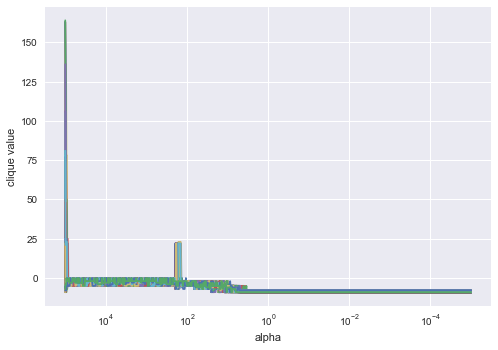

In [3]:
for e in range(n_epochs): plt.plot(alpha_evol, energies[e])
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('clique value')
plt.savefig('clique_values.png')

In [4]:
max_clique

array([-1, -1,  1, -1,  1,  1])

In [5]:
import itertools

ans = np.inf
y_ans = None
for y in np.array(list(map(list, itertools.product([-1, 1], repeat=6)))):
  if ans > mwc.energy(y, W, b):
    ans = mwc.energy(y, W, b)
    y_ans = y
print(ans, y_ans)

-9.0 [-1 -1  1 -1  1  1]


Worst clique value: -8.0


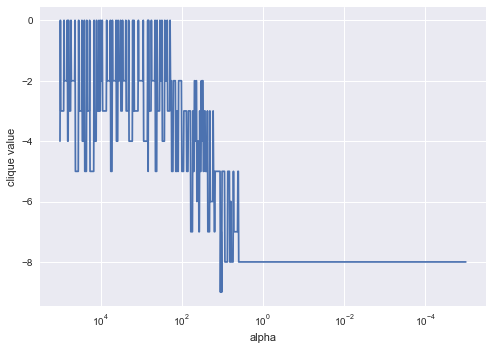

In [6]:
i = np.argmax(energies[:,-1])
print(f'Worst clique value: {energies[i][-1]}')
plt.plot(alpha_evol, energies[i])
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('clique value')
plt.show()

Best clique value: -9.0


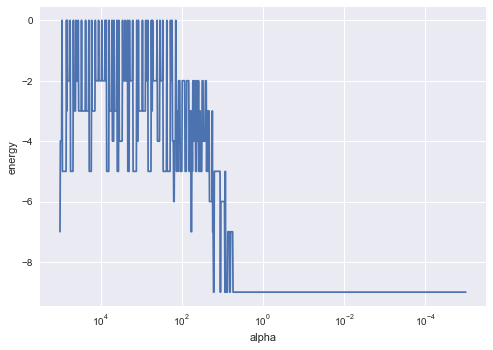

In [7]:
i = np.argmin(energies[:,-1])
print(f'Best clique value: {energies[i][-1]}')
plt.plot(alpha_evol, energies[i])
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('energy')
plt.show()